In [16]:
import pandas as pd
import time
import glob
import os
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as yf
import pickle

In [2]:
def pe(df, ticker):
    # print(df.columns)
    stock_price = yf.get_live_price(ticker)
    print(f"Harga saham terkini untuk {ticker}: {stock_price}")
    pe_ratio = stock_price / df['Diluted EPS']

    return pe_ratio[0]

In [3]:
def profitability(df):
    years = df['Date'].tolist()

    # Scores #1 and 2 - net income
    net_income = df.loc[df['Date'] == years[0], 'Net Income Common Stockholders'].values[0]
    net_income_py = df.loc[df['Date'] == years[1], 'Net Income Common Stockholders'].values[0]
    ni_score = 1 if net_income > 0 else 0
    ni_score_2 = 1 if net_income > net_income_py else 0

    # Score #3 - operating cash flow
    try:
        op_cf = df.loc[df['Date'] == years[0], 'Operating Cash Flow'].values[0]
    except:
        try:
            op_cf = df.loc[df['Date'] == years[1], 'EBITDA'].values[0]
        except:
            pretax_income = df.loc[df['Date'] == years[0], 'Pretax Income'].values[0]
            depreciation = df.loc[df['Date'] == years[0], 'Reconciled Depreciation'].values[0]
            op_cf = pretax_income + depreciation
    op_cf_score = 1 if op_cf > 0 else 0

    # Score #4 - change in RoA
    avg_assets = (df.loc[df['Date'] == years[0], 'Total Assets'].values[0]
                  + df.loc[df['Date'] == years[1], 'Total Assets'].values[0]) / 2
    avg_assets_py = (df.loc[df['Date'] == years[1], 'Total Assets'].values[0]
                     + df.loc[df['Date'] == years[2], 'Total Assets'].values[0]) / 2
    RoA = net_income / avg_assets
    RoA_py = net_income_py / avg_assets_py
    RoA_score = 1 if RoA > RoA_py else 0

    # Score #5 - Accruals
    total_assets = df.loc[df['Date'] == years[0], 'Total Assets'].values[0]
    accruals = op_cf / total_assets - RoA
    ac_score = 1 if accruals > 0 else 0

    # Hitung total skor profitabilitas
    # print(ni_score, ni_score_2, op_cf_score, RoA_score, ac_score)
    profitability_score = ni_score + ni_score_2 + op_cf_score + RoA_score + ac_score
    
    return profitability_score

In [4]:
def leverage(df):
    years = df['Date'].tolist()
    #Score #6 - long-term debt ratio
    try:
        
        total_debt = df.loc[df['Date'] == years[0], 'Total Debt'].values[0]
        total_assets = df.loc[df['Date'] == years[0], 'Total Assets'].values[0]
        debt_ratio = total_debt / total_assets
        debt_ratio_score = 1 if debt_ratio < 0.4 else 0
    except:
        debt_ratio_score = 1

    #Score #7 - Current ratio
    try:
        working_capital = df.loc[df['Date'] == years[0], 'Working Capital'].values[0]
        total_current_liabilities = df.loc[df['Date'] == years[0], 'Total Liabilities Net Minority Interest'].values[0] - (df.loc[df['Date'] == years[0], 'Total Debt'].values[0] - df.loc[df['Date'] == years[0], 'Net Debt'].values[0])
        current_ratio = (working_capital + total_current_liabilities) / total_current_liabilities
        current_ratio_score = 1 if current_ratio > 1 else 0
    except:
        current_ratio_score = 0

    leverage_score = debt_ratio_score + current_ratio_score

    return leverage_score

In [5]:
def operating_efficiency(df):
    global operating_efficiency_score

    years = df['Date'].tolist()
    
    #Score #8 - Gross margin
    revenue =df.loc[df['Date'] == years[0], 'Total Revenue'].values[0]
    revenue_py =df.loc[df['Date'] == years[1], 'Total Revenue'].values[0]
    try:
        gp = df.loc[df['Date'] == years[0], 'Gross Profit'].values[0]
        gp_py = df.loc[df['Date'] == years[1], 'Gross Profit'].values[0]
    except:
        try:
            expenses = df.loc[df['Date'] == years[0], 'Total Expenses'].values[0]
            expenses_py = df.loc[df['Date'] == years[0], 'Total Expenses'].values[0]
            gp = revenue - expenses
            gp_py = revenue_py - expenses_py
        except:
            gp = 0
            gp_py = 0
    
    gm = gp / revenue
    gm_py = gp_py / revenue_py
    # print(gm,gm_py)
    gm_score = 1 if gm > gm_py else 0
    
    #Score #9 - Asset turnover
    avg_assets = (df.loc[df['Date'] == years[0], 'Total Assets'].values[0] + df.loc[df['Date'] == years[1], 'Total Assets'].values[0]) / 2
    avg_assets_py = (df.loc[df['Date'] == years[1], 'Total Assets'].values[0] + df.loc[df['Date'] == years[2], 'Total Assets'].values[0]) / 2

    at = revenue / avg_assets #at = asset turnover
    at_py = revenue_py / avg_assets_py
    at_score = 1 if at > at_py else 0

    operating_efficiency_score = gm_score + at_score

    return operating_efficiency_score

In [7]:
folder_path = 'Laporan_keuangan'

all_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = []
results = []

for idx, file in enumerate(all_files):
    ticker = file.split('\\')[-1].split('_')[0]
    df = pd.read_csv(file)
    # if idx < 262:
    #     continue
    # Mengumpulkan hasil dari setiap fungsi
    try:
        pe_result = pe(df, ticker)
        profitability_result = profitability(df)
        leverage_result = leverage(df)
        operating_efficiency_result = operating_efficiency(df)
    except:
        continue
    
    # Menyimpan hasil dalam bentuk dictionary
    result = {
        'ticker': ticker,
        'pe_ratio': pe_result,
        'profitability': profitability_result,
        'leverage': leverage_result,
        'operating_efficiency': operating_efficiency_result
    }
    
    # Menambahkan hasil ke list
    results_df = pd.DataFrame([result])
    if not os.path.isfile('results.csv'):
        results_df.to_csv('results.csv', index=False)
    else:
        results_df.to_csv('results.csv', mode='a', header=False, index=False)
    time.sleep(2)
    # if idx == 50:
    #     break
results_df = pd.DataFrame(results)

results_df.to_csv('results.csv', index=False)



c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk J: 140.0399932861328


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KDP: 36.38999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KEYS: 156.3800048828125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KEY: 16.780000686645508


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KHC: 34.59000015258789


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KIM: 22.940000534057617


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KKR: 133.27999877929688


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KLAC: 787.3900146484375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KMB: 140.88999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KMI: 23.6200008392334


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KMX: 73.08999633789062


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KO: 70.16999816894531


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KR: 55.88999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk KVUE: 22.15999984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk K: 80.61000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LDOS: 166.38999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LEN: 182.25


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LHX: 243.66000366210938


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LH: 216.0


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LIN: 468.17999267578125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LKQ: 39.220001220703125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LLY: 887.1599731445312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LMT: 605.1300048828125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LNT: 60.189998626708984


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LOW: 267.760009765625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LRCX: 81.54000091552734


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LULU: 270.3800048828125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LUV: 31.25


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LVS: 52.58000183105469


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LW: 68.8499984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LYB: 96.75


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk LYV: 110.87000274658203


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk L: 79.27999877929688


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MAA: 154.6199951171875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MAR: 254.61000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MAS: 82.37000274658203


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MA: 497.70001220703125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MCD: 303.760009765625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MCHP: 77.68000030517578


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MCK: 485.4200134277344


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MCO: 460.5299987792969


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MDLZ: 71.51000213623047


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MDT: 88.26000213623047


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk META: 595.9400024414062


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MET: 84.04000091552734


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MGM: 40.43000030517578


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MHK: 154.44000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MKC: 80.61000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MKTX: 273.6499938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MLM: 524.1099853515625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MMC: 222.16000366210938


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MMM: 135.27000427246094


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MNST: 50.95000076293945


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MOH: 330.6700134277344


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MOS: 26.93000030517578


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MO: 50.099998474121094


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MPC: 171.97999572753906


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MPWR: 935.6099853515625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MRK: 109.7699966430664


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MRNA: 60.20000076293945


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MRO: 28.989999771118164


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MSCI: 589.719970703125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MSFT: 416.05999755859375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MSI: 450.29998779296875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MS: 107.87999725341797


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MTB: 178.74000549316406


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MTCH: 37.599998474121094


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MTD: 1452.8199462890625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk MU: 102.25


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NCLH: 20.389999389648438


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NDAQ: 72.12000274658203


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NDSN: 252.0


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NEE: 83.8499984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NEM: 53.34000015258789


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NFLX: 719.7000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NI: 34.63999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NKE: 82.25


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NOC: 536.739990234375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NOW: 917.6799926757812


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NRG: 95.3499984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NSC: 247.9199981689453


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NTAP: 123.38999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NTRS: 90.45999908447266


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NUE: 151.44000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NVDA: 124.91999816894531


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NVR: 9515.0


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NWSA: 26.139999389648438


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NWS: 27.510000228881836


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk NXPI: 234.24000549316406


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ODFL: 191.86000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk OKE: 95.2300033569336


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk OMC: 101.55000305175781


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ON: 71.54000091552734


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ORCL: 170.86000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ORLY: 1154.9000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk OTIS: 104.55999755859375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk OXY: 55.7599983215332


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk O: 62.0099983215332


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PANW: 342.3599853515625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PARA: 10.520000457763672


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PAYC: 167.97000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PAYX: 138.64999389648438


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PCAR: 103.41000366210938


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PCG: 19.709999084472656


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PEG: 92.02999877929688


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PEP: 167.97000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PFE: 28.579999923706055


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PFG: 87.31999969482422


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PGR: 255.36000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PG: 168.8800048828125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PHM: 139.44000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PH: 630.6799926757812


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PKG: 213.3699951171875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PLD: 122.41999816894531


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PM: 119.0999984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PNC: 182.25999450683594


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PNR: 95.87999725341797


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PNW: 87.9800033569336


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PODD: 229.94000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk POOL: 363.9100036621094


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PPG: 128.57000732421875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PPL: 32.54999923706055


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PRU: 122.98999786376953


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PSA: 345.3999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PSX: 138.6199951171875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PTC: 179.60000610351562


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PWR: 305.7200012207031


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk PYPL: 79.36000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk QCOM: 168.89999389648438


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk QRVO: 102.0


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RCL: 179.44000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk REGN: 1012.8200073242188


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk REG: 70.8499984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RF: 22.84000015258789


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RJF: 127.12999725341797


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RL: 196.1699981689453


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RMD: 233.97999572753906


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ROK: 267.010009765625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ROL: 49.81999969482422


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ROP: 544.8599853515625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ROST: 145.5800018310547


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RSG: 200.6699981689453


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RTX: 124.91000366210938


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk RVTY: 123.95999908447266


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SBAC: 235.3699951171875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SBUX: 96.58000183105469


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SCHW: 64.75


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SHW: 371.29998779296875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SJM: 117.38999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SLB: 45.459999084472656


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SMCI: 41.22999954223633


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SNA: 286.739990234375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SNPS: 499.1199951171875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SOLV: 67.73999786376953


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SO: 90.30999755859375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SPGI: 512.1699829101562


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SPG: 169.5800018310547


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SRE: 82.5999984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk STE: 231.02000427246094


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk STLD: 128.22000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk STT: 87.30999755859375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk STX: 107.23999786376953


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk STZ: 246.6699981689453


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SWKS: 96.83000183105469


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SWK: 107.37999725341797


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SW: 46.7599983215332


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SYF: 51.86000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SYK: 351.2200012207031


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk SYY: 75.41000366210938


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TAP: 56.06999969482422


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TDG: 1355.4599609375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TDY: 440.70001220703125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TECH: 74.77999877929688


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TEL: 145.4499969482422


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TER: 130.5


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TFC: 42.38999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TFX: 239.17999267578125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TGT: 152.8800048828125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TJX: 114.69000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TMO: 598.6099853515625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TMUS: 208.27999877929688


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TPR: 46.5


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TRGP: 158.02000427246094


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TRMB: 62.13999938964844


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TROW: 108.47000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TRV: 236.2100067138672


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TSCO: 294.9700012207031


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TSLA: 250.0800018310547


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TSN: 58.54999923706055


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TTWO: 151.69000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TT: 388.3599853515625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TXN: 202.7100067138672


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TXT: 86.73999786376953


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk TYL: 579.4500122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk T: 21.90999984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UAL: 59.220001220703125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UBER: 74.27999877929688


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UDR: 44.59000015258789


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UHS: 215.67999267578125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ULTA: 381.79998779296875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UNH: 591.2000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UNP: 238.86000061035156


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk UPS: 131.25


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk URI: 789.52001953125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk USB: 44.70000076293945


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VICI: 32.41999816894531


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VLO: 142.4199981689453


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VLTO: 112.0199966430664


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VMC: 241.42999267578125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VRSK: 265.6700134277344


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VRSN: 186.89999389648438


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VRTX: 455.30999755859375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VST: 138.41000366210938


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VTRS: 11.59000015258789


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VTR: 62.529998779296875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk VZ: 44.18000030517578


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk V: 277.92999267578125


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WAB: 183.3000030517578


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WAT: 352.510009765625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WBA: 8.720000267028809


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WBD: 7.78000020980835


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WDC: 66.3499984741211


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WEC: 95.4800033569336


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WELL: 125.55999755859375


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WFC: 56.959999084472656


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WMB: 49.630001068115234


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WMT: 80.94000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WM: 208.08999633789062


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WRB: 58.5099983215332


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WST: 296.5


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WTW: 290.69000244140625


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WYNN: 105.44999694824219


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk WY: 32.880001068115234


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk XEL: 63.72999954223633


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk XOM: 124.83000183105469


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk XYL: 133.47000122070312


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk YUM: 136.57000732421875


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ZBH: 104.68000030517578


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ZBRA: 366.7200012207031


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\yahoo_fin\stock_info.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.close[-1]


Harga saham terkini untuk ZTS: 190.02999877929688


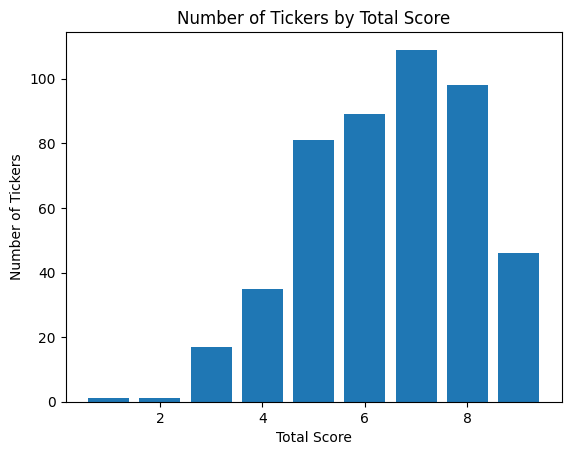

In [9]:
df_analisis= pd.read_csv('results.csv')

df_analisis['total_score'] = df_analisis['profitability'] + df_analisis['leverage'] + df_analisis['operating_efficiency']

score_counts = df_analisis['total_score'].value_counts().sort_index()

plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Total Score')
plt.ylabel('Number of Tickers')
plt.title('Number of Tickers by Total Score')
plt.show()

In [10]:
saham_fundamental_bagus = df_analisis[df_analisis['total_score'] == 9]
saham_fundamental_bagus

,ticker,pe_ratio,profitability,leverage,operating_efficiency,total_score
1,AAPL,34.520548,5,2,2,9
24,AMAT,22.693259,5,2,2,9
31,AMZN,44.513125,5,2,2,9
38,APH,37.142858,5,2,2,9
44,AVY,27.582262,5,2,2,9
68,BRO,30.446686,5,2,2,9
71,BWA,13.306819,5,2,2,9
77,CBOE,28.206434,5,2,2,9
86,CF,21.515513,5,2,2,9
88,CHRW,38.392088,5,2,2,9


In [11]:
with open('sp500tickers.pickle', 'rb') as file:
    sp500_tickers = pickle.load(file)
ticker_identity = pd.DataFrame(sp500_tickers)
ticker_identity

,ticker,company name,sektor
0,MMM,3M,Industrial Conglomerates
1,AOS,A. O. Smith,Building Products
2,ABT,Abbott Laboratories,Health Care Equipment
3,ABBV,AbbVie,Biotechnology
4,ACN,Accenture,IT Consulting & Other Services
...,...,...,...
498,XYL,Xylem Inc.,Industrial Machinery & Supplies & Components
499,YUM,Yum! Brands,Restaurants
500,ZBRA,Zebra Technologies,Electronic Equipment & Instruments
501,ZBH,Zimmer Biomet,Health Care Equipment


In [12]:
saham_fundamental_bagus = pd.merge(saham_fundamental_bagus, ticker_identity, on='ticker', how='left')

saham_fundamental_bagus

,ticker,pe_ratio,profitability,leverage,operating_efficiency,total_score,company name,sektor
0,AAPL,34.520548,5,2,2,9,Apple Inc.,"Technology Hardware, Storage & Peripherals"
1,AMAT,22.693259,5,2,2,9,Applied Materials,Semiconductor Materials & Equipment
2,AMZN,44.513125,5,2,2,9,Amazon,Broadline Retail
3,APH,37.142858,5,2,2,9,Amphenol,Electronic Components
4,AVY,27.582262,5,2,2,9,Avery Dennison,Paper & Plastic Packaging Products & Materials
5,BRO,30.446686,5,2,2,9,Brown & Brown,Insurance Brokers
6,BWA,13.306819,5,2,2,9,BorgWarner,Automotive Parts & Equipment
7,CBOE,28.206434,5,2,2,9,Cboe Global Markets,Financial Exchanges & Data
8,CF,21.515513,5,2,2,9,CF Industries,Fertilizers & Agricultural Chemicals
9,CHRW,38.392088,5,2,2,9,C.H. Robinson,Air Freight & Logistics


In [13]:
saham_fundamental_bagus.to_csv("best_fundamental.csv",index=False)